In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
df = pd.read_csv('match_csv')

In [15]:
list(df['Class'])

['BL Lac',
 'BL Lac',
 'BL Lac',
 'QSO RLoud flat radio sp.',
 'QSO RLoud flat radio sp.',
 'QSO RLoud flat radio sp.',
 'BL Lac',
 'BL Lac',
 'BL Lac',
 'BL Lac',
 'BL Lac',
 'QSO RLoud flat radio sp.',
 'QSO RLoud flat radio sp.',
 'QSO RLoud flat radio sp.',
 'QSO RLoud flat radio sp.',
 'BL Lac',
 'QSO RLoud flat radio sp.',
 'BL Lac-galaxy dominated',
 'BL Lac',
 'BL Lac',
 'BL Lac-galaxy dominated',
 'BL Lac',
 'BL Lac',
 'QSO RLoud flat radio sp.',
 'QSO RLoud flat radio sp.',
 'QSO RLoud flat radio sp.',
 'BL Lac',
 'BL Lac',
 'QSO RLoud flat radio sp.',
 'BL Lac',
 'QSO RLoud flat radio sp.',
 'BL Lac',
 'BL Lac',
 'BL Lac',
 'BL Lac',
 'BL Lac-galaxy dominated',
 'BL Lac',
 'BL Lac',
 'Blazar Uncertain type',
 'BL Lac',
 'QSO RLoud flat radio sp.',
 'QSO RLoud flat radio sp.',
 'BL Lac Candidate',
 'BL Lac',
 'BL Lac',
 'QSO RLoud flat radio sp.',
 'BL Lac',
 'BL Lac',
 'BL Lac',
 'BL Lac',
 'BL Lac',
 'BL Lac',
 'QSO RLoud flat radio sp.',
 'QSO RLoud flat radio sp.',
 'Blaz

In [4]:
input_vector = df[['FR', 'Rmag', 'FX', 'z']].values
input_vector.shape

(1765, 4)

In [5]:
output_vector = df['Class'].values
index = np.where(output_vector == 'Blazar Uncertain type')[0][0]

In [6]:
target_classes = ['BL Lac', 'QSO RLoud flat radio sp.']

filtered_df = df[df['Class'].isin(target_classes)]

input_vector = filtered_df[['FR', 'Rmag', 'FX', 'z']].values
output_vector = filtered_df['Class'].values

In [7]:
binary_labels = (output_vector == "BL Lac").astype(int)

In [8]:
input_tensor = torch.from_numpy(input_vector).to(dtype=torch.float32)
output_tensor = torch.from_numpy(binary_labels).to(dtype=torch.float32)

full_dataset = TensorDataset(input_tensor, output_tensor)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 2.4432
Epoch 11/100, Loss: 0.4005
Epoch 21/100, Loss: 0.4506
Epoch 31/100, Loss: 0.2909
Epoch 41/100, Loss: 0.1741
Epoch 51/100, Loss: 0.2597
Epoch 61/100, Loss: 0.3076
Epoch 71/100, Loss: 0.2448
Epoch 81/100, Loss: 0.1205
Epoch 91/100, Loss: 0.2288


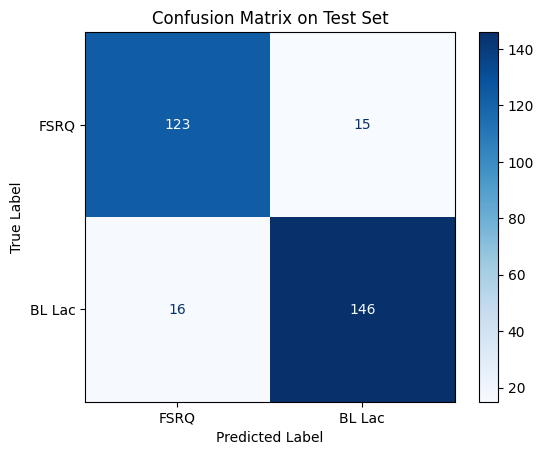

In [11]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        predictions = (outputs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

labels = ["FSRQ", "BL Lac"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Predicting on BCUs

In [41]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

df_unlabelled = pd.read_csv('match_csv')

target_class = ['Blazar Uncertain type']
filtered_df = df_unlabelled[df_unlabelled['Class'].isin(target_class)]

input_vector = filtered_df[['FR', 'Rmag', 'FX', 'z']].values

input_tensor = torch.from_numpy(input_vector).to(dtype=torch.float32)

dataset = TensorDataset(input_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():
    for batch in loader:
        inputs = batch[0]
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()
        predictions.extend(preds.cpu().numpy())

filtered_df = df_unlabelled[df_unlabelled['Class'].isin(target_class)].copy()

filtered_df.loc[:, 'Predicted_Label'] = predictions  # This will be 0.0 or 1.0

label_map = {0.0: 'FSRQ', 1.0: 'BL Lac'}
filtered_df.loc[:, 'Predicted_Class'] = filtered_df['Predicted_Label'].map(label_map)

filtered_df.to_csv("predicted_unlabelled_data.csv", index=False)

In [43]:
filtered_df

,Source_Name,DataRelease,RAJ2000,DEJ2000,GLON_1,GLAT_1,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,...,FR,F143,FX,FF,aro,RA_deg,DEC_deg,Separation,Predicted_Label,Predicted_Class
38,4FGL J0023.7+4457,1,5.9477,44.9510,117.804470,-17.645323,0.045021,0.030651,-58.78,0.0730,...,140.0,0,0.00,7.000000e-10,0.761,5.897667,44.943278,0.049303,0.0,FSRQ
54,4FGL J0040.3+4050,1,10.0989,40.8362,120.679780,-21.987257,0.020290,0.017823,68.04,0.0329,...,47.0,0,1.05,0.000000e+00,0.530,10.057500,40.834639,0.115379,1.0,BL Lac
65,4FGL J0049.6-4500,1,12.4188,-45.0086,303.946530,-72.116180,0.049400,0.045391,44.09,0.0801,...,206.0,0,2.31,0.000000e+00,0.388,12.319167,-44.953058,0.298260,1.0,BL Lac
80,4FGL J0058.4+3315,1,14.6101,33.2505,124.615616,-29.598356,0.033612,0.031021,-41.56,0.0545,...,161.0,0,0.00,8.000000e-10,0.729,14.633542,33.188169,0.308489,0.0,FSRQ
84,4FGL J0100.3+0745,1,15.0932,7.7647,126.796390,-55.039993,0.011656,0.010793,-39.01,0.0189,...,99.0,0,0.00,2.000000e-09,0.769,15.086667,7.764278,0.202328,1.0,BL Lac
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,4FGL J2250.4-4206,1,342.6062,-42.1095,353.756260,-61.174088,0.019735,0.017022,-84.61,0.0320,...,82.0,0,0.00,6.000000e-10,0.411,342.592542,-42.103719,0.122833,0.0,FSRQ
1674,4FGL J2250.7-2806,1,342.6903,-28.1114,23.751673,-63.319077,0.010978,0.010484,-74.67,0.0178,...,306.0,228,0.34,3.400000e-09,0.684,342.685375,-28.110919,0.036892,1.0,BL Lac
1675,4FGL J2251.7-3208,1,342.9436,-32.1396,14.737649,-63.607050,0.028123,0.023251,-38.58,0.0456,...,3.0,0,2.31,0.000000e+00,0.273,342.948042,-32.103639,0.309015,1.0,BL Lac
1694,4FGL J2302.8-1841,1,345.7152,-18.6985,45.838160,-63.682007,0.039162,0.033365,-27.36,0.0635,...,861.0,0,5.15,0.000000e+00,0.487,345.762417,-18.690500,0.061434,1.0,BL Lac
